In [2]:
import sys; sys.path.insert(0, '../')
from dist_tools import *

%matplotlib inline

/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
pd.options.display.max_rows = 10000

In [4]:
usps, fips, epsg, seats = "TX", 48, 3665, 36

Generate a list of Texas counties, for the hard cells of the fuzzy match.

In [5]:
tx_co = pd.read_sql("SELECT county, name FROM counties_2016 WHERE state = 48 ORDER BY county;",
                    con = psycopg2.connect(database = "census", user = user, password = passwd,
                                           host = "saxon.harris.uchicago.edu", port = 5432))
tx_co = list(tx_co.county)

Load the tracts.

In [12]:
pr_query = """SELECT state, county cid,
                     REGEXP_REPLACE(UPPER(name), '^0+', '') AS vtd,
                     ST_Transform(geom, 3665) geometry
              FROM vtd_2010
              WHERE state = 48
              ORDER BY state, cid, vtd;"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

prdf = gpd.GeoDataFrame.from_postgis(pr_query, con, 
                                     geom_col = "geometry", 
                                     crs = from_epsg(epsg))

In [38]:
votes = {}

Fuzzy match for the earlier, 1996-2004 data.  Final merge includes on the precinct geometries.

In [39]:
for y in [1996, 2000, 2004, 2008]:
    
    yv = "{:02d}".format(y % 100)

    votes[y] = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/TX_%d.tab" % y, sep = "\t")\
                 .sort_values(by = ["county", "vtd"])\
                 .rename(columns = {"fips" : "cid", "vtd" : "vtd_tx", 
                                    "g{}_USP_dv".format(y) : "D" + yv, 
                                    "g{}_USP_rv".format(y) : "R" + yv})\
                 [["cid", "county", "vtd_tx", "D" + yv, "R" + yv]]
    votes[y].vtd_tx = votes[y].vtd_tx.str.replace(r'^0+', r'') # improve match rate....

    votes[y]['vtd'] = "NOMATCH"

    # Hard match first.
    for cid in tx_co:
        votes[y].loc[votes[y].cid == cid, 'vtd'] = \
            votes[y][votes[y].cid == cid]['vtd_tx'].\
                apply(lambda x: jf_jw_match(x, prdf[prdf.cid == cid]["vtd"])[0])

    votes[y].loc[votes[y].vtd_tx != votes[y].vtd, "vtd_tx"] = \
        votes[y][votes[y].vtd_tx != votes[y].vtd].vtd_tx.str.replace(r'[ABC]$', r'')
        
    for cid in tx_co:
        votes[y].loc[votes[y].cid == cid, 'vtd'] = \
            votes[y][votes[y].cid == cid]['vtd_tx'].\
                apply(lambda x: jf_jw_match(x, prdf[prdf.cid == cid]["vtd"])[0])
    
    votes[y] = pd.merge(prdf, votes[y], how = "right", on = ["cid", "vtd"])\
                 [['cid', 'county', 'vtd', 'D' + yv, 'R' + yv, "geometry"]]

    print(y, end = " ")
    

1996 2000 2004 2008 

Load the newer, 2016 VTDs.  Prepare the merge a little bit.

In [40]:
tx_state_shp = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/tx_site/tx_vtd_2016/VTDs.shp")
tx_state_shp = tx_state_shp[['CNTY', 'VTD', 'geometry']].rename(columns = {"CNTY" : "cid", "VTD" : "vtd"})
tx_state_shp.vtd = tx_state_shp.vtd.str.replace(r'^0+', r'') # improve match rate....
# tx_state_shp.geometry = tx_state_shp.geometry.centroid
tx_state_shp = tx_state_shp.sort_values(by = ["cid", "vtd"]).reset_index()[["cid", "vtd", "geometry"]]
tx_state_shp = tx_state_shp.to_crs(epsg = epsg)

Finally, we're doing an attribute join to join the (geo-matched) tract/precincts to the votes, on the VTD key.

In [41]:
for y in [2012, 2016]:
    yv = "{:02d}".format(y%100)
    votes[y] = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/tx_site/tx_%d.csv" % y, sep = ",")\
                 .sort_values(by = ["County", "VTD"])\
                 .rename(columns = {"FIPS" : "cid", "VTD" : "vtd", "County" : "county"})
            
    votes[y] = votes[y][votes[y].Votes > 0]
    votes[y] = votes[y][["cid", "county", "vtd", "Party", "Votes"]] # D" + yv, "R" + yv]]
    votes[y].vtd = votes[y].vtd.str.replace(r'^0+', r'') # improve match rate....
    votes[y].Party += yv
    
    votes[y] = pd.pivot_table(votes[y], values = "Votes", index = ["county", "cid", "vtd"], columns = ["Party"])
    votes[y] = votes[y].fillna(0).astype(int).reset_index()[["cid", "county", "vtd", "D" + yv, "R" + yv]]
    
    votes[y].cid = votes[y].cid.astype(int)
    
    votes[y] = pd.merge(tx_state_shp, votes[y], on = ["cid", "vtd"])
    
    # votes[y] = votes[y].groupby("rn").sum()[['D' + yv, 'R' + yv]]

In [67]:
for y in [1996, 2000, 2004, 2008, 2012, 2016]:
    yv = "{:02d}".format(y%100)
    votes[y]["DFrac"] = votes[y]["D" + yv] / (votes[y]["D" + yv] + votes[y]["R" + yv]) 
    output_geojson(votes[y].set_geometry(votes[y].geometry.simplify(10)), 
                   var = "DFrac", fname = "mapped/tx_{}.geojson".format(y))

In [60]:
tr_rn = get_tr_rn(usps, epsg)

In [71]:
votes[2016].head()

,cid,vtd,geometry,county,D16,R16,DFrac
0,1,1,"POLYGON ((1913952.81904669 7522869.349874464, ...",Anderson,248,726,0.254620
1,1,10,"POLYGON ((1901166.115547035 7528709.469550963,...",Anderson,36,280,0.113924
2,1,11,"POLYGON ((1883756.004242062 7541436.514961479,...",Anderson,131,568,0.187411
3,1,13,"POLYGON ((1914108.621996981 7527054.429392653,...",Anderson,253,723,0.259221
4,1,15,"POLYGON ((1929513.640076825 7533190.170823907,...",Anderson,84,481,0.148673


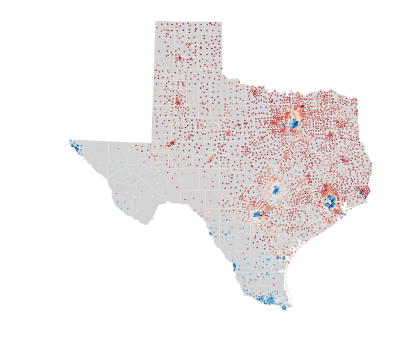

In [72]:
ax = tr_rn.plot(color = "lightgrey", figsize = (6, 6))
votes[2016].set_geometry(votes[2016].centroid)\
           .plot(column = "DFrac", cmap = "RdBu", markersize = 1, ax = ax)
ax.set_axis_off()

In [64]:
tr_votes = [merge_tract_number(tr_rn, votes[y])[["D{:02d}".format(y%100), "R{:02d}".format(y%100)]]
            for y in range(1996, 2017, 4)]

tx_tr_votes = pd.concat(tr_votes, axis = 1).sort_index()
tx_tr_votes = tx_tr_votes.fillna(0).astype(int)

In [65]:
tx_tr_votes.fillna(0).filter(regex = '[RD][0-9]+', axis = 1).to_csv("votes/tx.csv")

In [68]:
pd.read_csv("votes/tx.csv", index_col = "rn").head()

,D96,R96,D00,R00,D04,R04,D08,R08,D12,R12,D16,R16
rn,,,,,,,,,,,,
0,728,883,715,1480,661,1710,564,1881,489,1872,382,2162
1,59,97,77,214,128,243,52,274,40,268,36,280
3,511,551,433,798,403,920,425,855,541,1280,490,1245
4,1121,773,989,1120,861,1226,881,1171,792,1095,701,1061
5,392,76,363,123,300,215,463,228,377,309,313,346
